# Adapted from:  http://www.bioconductor.org/help/workflows/rnaseqGene/

#### To learn basics of R: https://www.datacamp.com/courses/free-introduction-to-r

# Table of Contents

1. [Setup](#Setup)
1. [Create DESeq Data Set](#Create-DESeq-Data-Set)
1. [Calculate TPM](#Calculate-TPM)
1. [PCA and Clustering](#PCA-and-Clustering)
    1. [PCA](#PCA)
    1. [Clustering](#Clustering)
1. [Find DEGs](#Find-DEGs)

# Setup

In [1]:
suppressPackageStartupMessages(library('SummarizedExperiment'))
suppressPackageStartupMessages(library('GenomicFeatures'))
suppressPackageStartupMessages(library('DESeq2'))

# Create DESeq Data Set

In [2]:
load('../processed_data/se.rda')

Create the DESeqDataSet, and designate the experimental design. The experimental design can include information from the colData. Use ~1 to ignore design criteria.

In [3]:
colnames(se)

[1] "wt_fe2_1"     "wt_fe2_2"     "wt_dpd_1"     "wt_dpd_2"     "delfur_fe2_1"
[6] "delfur_fe2_2" "delfur_dpd_1" "delfur_dpd_2"

In [4]:
# Designate groups for comparisons by removing the replicate subscript from colnames
colData(se)$group <- gsub('.{2}$', '', colnames(se))
colData(se)$group

[1] "wt_fe2"     "wt_fe2"     "wt_dpd"     "wt_dpd"     "delfur_fe2"
[6] "delfur_fe2" "delfur_dpd" "delfur_dpd"

In [5]:
dds <- DESeqDataSet(se, design = ~group)

Warning message in DESeqDataSet(se, design = ~group):
“some variables in design formula are characters, converting to factors”

Remove genes that have 0 counts across experimental conditions

In [6]:
nrow(dds)
dds <- dds[rowSums(assay(dds)) > 0, ]
nrow(dds)

[1] 4386

[1] 4368

In [7]:
head(assay(dds))

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,2303,2354,311,284,3019,3485,245,232
b0002,36937,25801,58117,60901,40532,38470,17890,23112
b0003,10922,8250,16854,21042,11589,10840,4805,7879
b0004,11953,8463,12127,14498,10077,9532,3727,5103
b0005,472,345,216,178,362,297,104,120
b0006,669,588,703,633,682,653,660,767


# Calculate TPM

In [8]:
fpkm_data <- fpkm(dds)
head(fpkm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,4755.5713,5818.9772,538.16942,532.27483,5856.0006,7072.9981,424.78352,391.13893
b0002,2073.9796,1734.2465,2734.61328,3103.67411,2137.8151,2123.0345,843.42411,1059.53348
b0003,1617.8522,1462.9250,2092.13424,2828.99730,1612.5452,1578.1852,597.61693,952.88850
b0004,1283.9397,1088.2370,1091.61865,1413.46359,1016.7828,1006.3377,336.13978,447.53558
b0005,219.1338,191.7423,84.03707,75.00602,157.8720,135.5239,40.54091,45.48653
b0006,118.9680,125.1736,104.76330,102.16838,113.9246,114.1325,98.54639,111.36113


In [9]:
tpm_data <- sweep(fpkm_data,2,colSums(fpkm_data),`/`)*1e6 # Divide each column by the column sum (times 1e6)
head(tpm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,3485.20690,4234.6825,478.50593,479.12630,4813.58088,5798.12160,370.68256,343.88450
b0002,1519.95366,1262.0746,2431.44374,2793.76705,1757.26514,1740.36693,736.00456,931.52870
b0003,1185.67244,1064.6241,1860.19235,2546.51718,1325.49792,1293.72433,521.50369,837.76775
b0004,940.95854,791.9498,970.59769,1272.32688,835.78651,824.94978,293.32859,393.46773
b0005,160.59616,139.5379,74.72041,67.51654,129.76939,111.09628,35.37757,39.99120
b0006,87.18785,91.0934,93.14884,91.96670,93.64503,93.56058,85.99540,97.90732


In [10]:
write.csv(tpm_data, file = "../processed_data/deseq2-tpm.csv")

# PCA and clustering

Raw counts from RNAseq tend to be exponentially distributed, so a log transform must be applied before running linear methods such as PCA or clustering. Since some counts can be 0, we must apply log(x + 1) to avoid infinite values. However, due to technical reasons, genes with lower counts have higher variance than genes with higher counts. PCA works best with constant variance, so to fix this DESeq2 has a model-based regularized log transform (rlog) to normalize the variance. The rlog counts are only used for this QC step, and should not be used for finding DEGs or other statistical tests.

In [11]:
rld <- rlog(dds)

In [12]:
library("pheatmap")
library("RColorBrewer")

## PCA

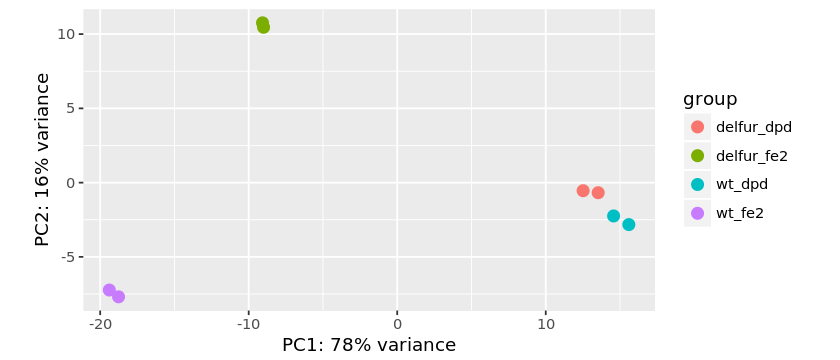

In [13]:
options(repr.plot.width=7, repr.plot.height=3)
plotPCA(rld,intgroup=c('group'))

## Clustering

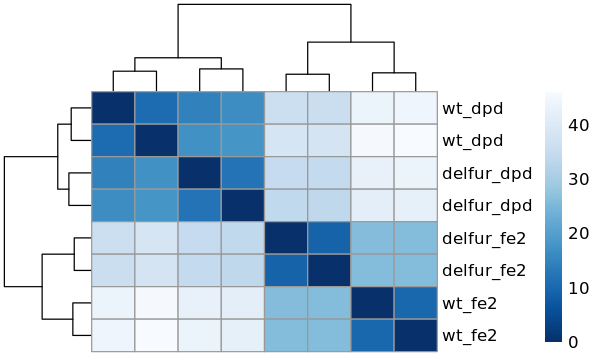

In [14]:
options(repr.plot.width=5, repr.plot.height=3)
# Generate (euclidean) distance matrix
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix( sampleDists )
# Designate the names for the rows
rownames(sampleDistMatrix) <- colData(rld)$group
# Designate the names for the columns
colnames(sampleDistMatrix) <- NULL
# Choose color palette
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
# Create heatmap
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

# Find DEGs

In [15]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Designate which groups you want to compare for DEGs.

In [16]:
res_FeCl2 <- results(dds,contrast = c('group','delfur_fe2','wt_fe2'))
res_DPD <- results(dds,contrast = c('group','delfur_dpd','wt_dpd'))

Put results into table form. Log2foldchange is positive if the first group (e.g. delfur_fe2) is larger than the second (e.g. wt_fe2)

In [17]:
resTable_FeCl2 <- data.frame(res_FeCl2@listData,row.names = res_FeCl2@rownames)
resTable_DPD <- data.frame(res_DPD@listData,row.names = res_DPD@rownames)

In [18]:
head(resTable_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0001,1639.8918,0.29049700,0.1408963,2.0617781,0.039228863,0.14129556
b0002,37554.3766,0.16198085,0.1370202,1.1821678,0.237139129,0.50521185
b0003,11473.6782,0.05055377,0.1881449,0.2686959,0.788163733,0.91265936
b0004,9540.8153,-0.22971528,0.1589479,-1.4452237,0.148395065,0.36786307
b0005,272.7208,-0.48684824,0.1736124,-2.8042244,0.005043778,0.02655896
b0006,666.7746,-0.09770109,0.1317905,-0.7413363,0.458489532,0.72360253


In [19]:
deg_FeCl2 <- resTable_FeCl2[complete.cases(resTable_FeCl2[,c('padj','log2FoldChange')]) & 
                            # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                            resTable_FeCl2$padj < .05 & # Adjusted p-value cutoff of 0.05
                            abs(resTable_FeCl2$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

deg_DPD <- resTable_DPD[complete.cases(resTable_DPD[,c('padj','log2FoldChange')]) & 
                        # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                        resTable_DPD$padj < .05 & # Adjusted p-value cutoff of 0.05
                        abs(resTable_DPD$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

In [20]:
head(deg_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0034,166.3882,-1.146223,0.2145647,-5.342084,9.188428e-08,1.372695e-06
b0118,24663.8057,-1.332324,0.1002175,-13.294335,2.496831e-40,1.278896e-38
b0123,3275.9626,-2.059760,0.1186186,-17.364571,1.530400e-67,1.508974e-65
b0150,7195.7090,1.108790,0.1464946,7.568811,3.766556e-14,8.537526e-13
b0152,424.6157,1.064129,0.1729466,6.152935,7.606202e-10,1.357414e-08
b0273,3505.2194,-1.201679,0.2065283,-5.818472,5.938795e-09,1.000966e-07
